In [ ]:
import torch
from trainer import Trainer
from models import NN_CartPole, NN_Humanoid

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("You are using device: %s" % device)

You are using device: cuda:0


In [4]:
str_env = "Humanoid-v5"
# str_env = "CartPole-v1"

In [ ]:
# Configurations
configs = {
    # Number of updates
    'updates': 5000,
    # Number of epochs to train the model with sampled data.
    'epochs': 32,
    # Number of worker processes
    'N': 64,
    # Number of steps to run on each process for a single update
    'T': 1024,
    # Number of mini batches
    'batches': 4,
    # Value loss coefficient.
    'value_loss_coef': 1.0,
    # Entropy bonus coefficient.
    'entropy_bonus_coef': 1e-5,
    # Clip range.
    'clip_range': 0.1,
    # Learning rate.
    'learning_rate': 1e-4,
    # Learning rate decay.
    'learning_rate_decay': 0.999,
    # Model to use
    'model': NN_CartPole(4, 2, str_env) if str_env == "CartPole-v1" else NN_Humanoid(348, 17, str_env),
    # Device to use for training
    'device': device,
    # Environment to use
    'str_env': str_env,
    # Reward scaling
    'reward_scaling': 1.0 if str_env == "CartPole-v1" else 0.005
}

# Initialize the trainer
trainer = Trainer(**configs)

In [ ]:
# # Load checkpoint and save video
# checkpoint = torch.load("checkpoint/" + str_env + "_model.pth", weights_only=True, map_location=device)
# trainer.model.load_state_dict(checkpoint)
# if device != torch.device("cuda:0") or str_env == "CartPole-v1":
#     trainer.log_video(str_env)

In [ ]:
# Run and monitor the experiment
trainer.run_training_loop()

# Stop the workers
trainer.destroy()

  0%|          | 3/5000 [00:58<26:55:32, 19.40s/it]


KeyboardInterrupt: 

: 

In [ ]:
if device != torch.device("cuda:0") or str_env == "CartPole-v1":
    trainer.log_video(str_env)

# Save the model
torch.save(trainer.model.state_dict(), "checkpoint/model.pth")

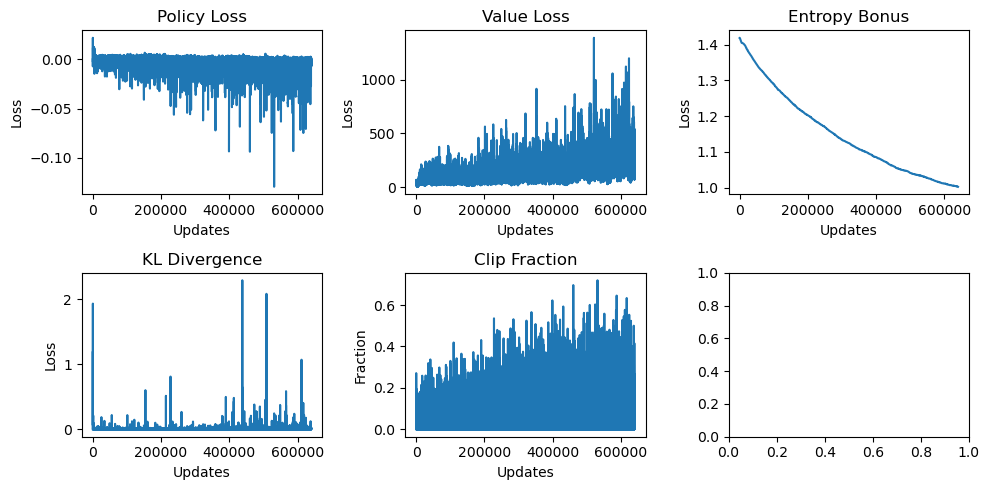

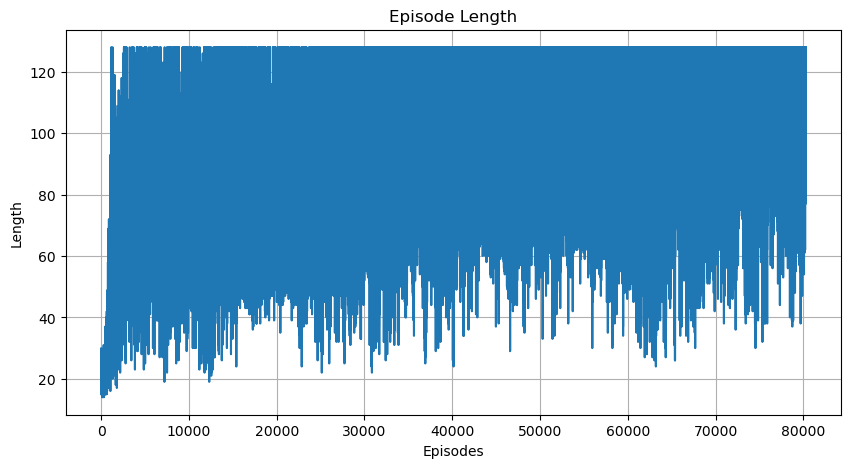

In [ ]:
trainer.plot()